In [1]:
import os
import pandas as pd
import sklearn
import regex as re

import tensorflow as tf
from tensorflow.keras import Model, Sequential
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import LSTM


In [5]:
%cd ../content/drive/MyDrive/COLAB/

/content/drive/MyDrive/COLAB


In [6]:
twitter_data=pd.read_csv('CVAssignmentDataset.csv')

In [9]:
tweets=twitter_data['Text']
labels=twitter_data['Class']

In [ ]:
print(tweets)

In [12]:
def clean_tweet(text):
  for i in range(len(text)):
    text[i]=' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", text[i]).split())
  return text



clean_tweets=clean_tweet(tweets)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [13]:
text_ds=tf.data.Dataset.from_tensor_slices(clean_tweets)


In [14]:
# Vocabulary size and number of words in a sequence.
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  return lowercase

vocab_size = 10000
sequence_length = 50

# Use the text vectorization layer to normalize, split, and map strings to 
# integers. Note that the layer uses the custom standardization defined above. 
# Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = tf.keras.layers.experimental.preprocessing.TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
vectorize_layer.adapt(text_ds)

In [15]:
def classifier():
  model = Sequential()
  # model.add(layers.InputLayer((50,)))
  model.add(vectorize_layer)
  model.add(layers.Embedding(10000,32,input_length=50))
  # print(model.output_shape)
  model.add(layers.Conv1D(32,1))
  # print(model.output_shape)
  model.add(layers.MaxPool1D())
  # print(model.output_shape)
  model.add(layers.Bidirectional(LSTM(256,return_sequences=True)))
  # print(model.output_shape)
  model.add(layers.Dropout(0.2))
  model.add(layers.Bidirectional(LSTM(256)))
  # print(model.output_shape)
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(1024,'relu'))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(512,'relu'))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(1,'sigmoid'))
  return model




In [16]:
clf=classifier()
# tf.keras.utils.plot_model(clf, show_shapes=True, dpi=64)

In [17]:
clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
clf.fit(clean_tweets,labels,batch_size=16,epochs=10)

Epoch 1/10
5404/5404 [==============================] - 106s 17ms/step - loss: 0.5843 - accuracy: 0.6657
Epoch 2/10
5404/5404 [==============================] - 95s 18ms/step - loss: 0.4251 - accuracy: 0.7961
Epoch 3/10
5404/5404 [==============================] - 95s 18ms/step - loss: 0.3636 - accuracy: 0.8262
Epoch 4/10
5404/5404 [==============================] - 95s 18ms/step - loss: 0.3082 - accuracy: 0.8554
Epoch 5/10
5404/5404 [==============================] - 94s 17ms/step - loss: 0.2532 - accuracy: 0.8837
Epoch 6/10
5404/5404 [==============================] - 92s 17ms/step - loss: 0.2022 - accuracy: 0.9094
Epoch 7/10
5404/5404 [==============================] - 95s 17ms/step - loss: 0.1596 - accuracy: 0.9295
Epoch 8/10
5404/5404 [==============================] - 95s 18ms/step - loss: 0.1245 - accuracy: 0.9462
Epoch 9/10
5404/5404 [==============================] - 95s 18ms/step - loss: 0.1010 - accuracy: 0.9567
Epoch 10/10
5404/5404 [==============================] - 95s 18

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 50)                0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 32)            320000    
_________________________________________________________________
conv1d (Conv1D)              (None, 50, 32)            1056      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 25, 32)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 25, 512)           591872    
_________________________________________________________________
dropout (Dropout)            (None, 25, 512)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               1

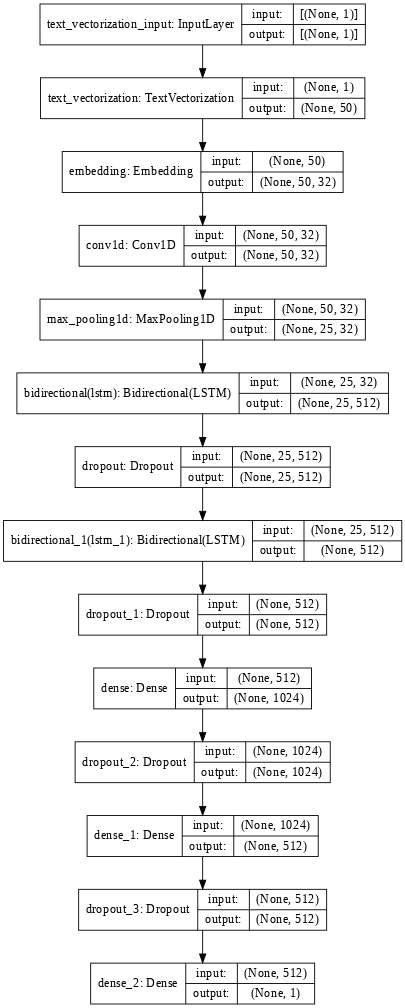

In [25]:
clf.summary()
tf.keras.utils.plot_model(clf, show_shapes=True, dpi=64)